## Autoencoders para remoção de ruídos
Baseado no Tutorial de Autoencoder do TensorFlow
##### Copyright 2020 The TensorFlow Authors. - https://www.tensorflow.org/tutorials/generative/autoencoder

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

Carregar dataset, normalizar e adicionar uma dimensão

In [ ]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

print(x_train.shape)

4431872/4422102 [==============================] - 0s 0us/step
(60000, 28, 28, 1)


Adicionar ruído Gaussiano às imagens. Manter valores entre 0 e 1

In [ ]:
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape) 
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape) 

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

Plotar 10 imagens com ruído

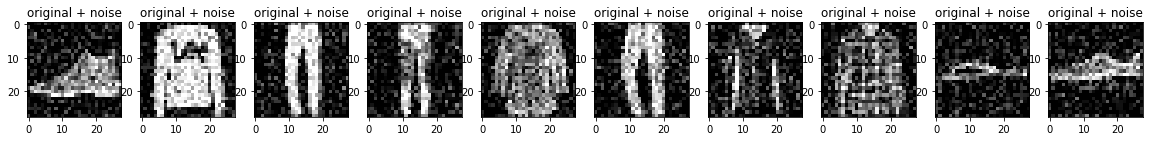

In [ ]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

Definir um autoencoder convolucional: [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) para o encoder; [Conv2DTranspose](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose), ou [convolução transposta](https://towardsdatascience.com/transposed-convolution-demystified-84ca81b4baba) para o decoder

In [ ]:
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(28, 28, 1)),
      layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
      layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])

    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Denoise()
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

Características do encoder:

In [ ]:
autoencoder.encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 8)           1160      
                                                                 
Total params: 1,320
Trainable params: 1,320
Non-trainable params: 0
_________________________________________________________________


Treinar

In [ ]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/10
1875/1875 [==============================] - 20s 3ms/step - loss: 0.0168 - val_loss: 0.0102
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0096 - val_loss: 0.0094
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0087 - val_loss: 0.0083
Epoch 4/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0081 - val_loss: 0.0080
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0078 - val_loss: 0.0077
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0075 - val_loss: 0.0075
Epoch 7/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0073 - val_loss: 0.0073
Epoch 8/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0072 - val_loss: 0.0072
Epoch 9/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0071 - val_loss: 0.0071
Epoch 10/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.00

Características do Decoder (só é possivel obter apos treinar)

In [ ]:
autoencoder.decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose (Conv2DTra  (None, 14, 14, 8)        584       
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 16)       1168      
 ranspose)                                                       
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 1)         145       
                                                                 
Total params: 1,897
Trainable params: 1,897
Non-trainable params: 0
_________________________________________________________________


Codificar e decodificar imagens do conjunto de teste (AE não as viu no treino)

In [ ]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

Plotar imagens c/ ruido e filtradas

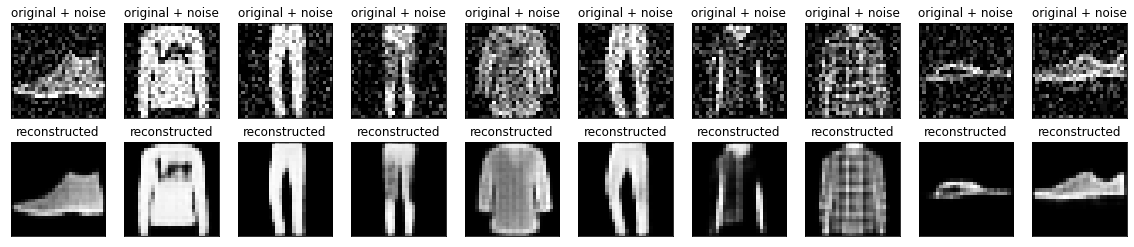

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()